# LoL Churn Predictor [Part 3 - Data Modeling]

**David Skarbrevik - 2018**

In part 2 we cleaned and analyzed our League of Legends data. Now we want to use that data to build a model that completes some sort of churn-like prediction.

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Planning</a></li></h3>
    <br>
    <h3><li><a href="#section2">Prepparing the data for modeling</a></li></h3>
    <br>
    <h3><li><a href="#section3">Baseline model</a></li></h3>
    <br>
    <h3><li><a href="#section4">Neural Network model</a></li></h3>
</ol>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<a id='section1'></a>

## Step 1) Planning

### What preprocessing steps maybe necessary before fitting data to a model?

**There are four things we may need/want to do before training our models:**

**1)** OHE encode categorical and binary features

**2) [optional]** normalize values (many columns have large values)

**3)** create a "label" feature that we will predict on

**4)** remove unwanted features from the dataset


### What prediction tasks to model?

Some possibilities:

* Will the summoner get to level 3 or higher within the first month of play?
* Did the summoner play more than 1 match?
* Did the summoner play at least X matches?



### What types of models to try?

I will start with logistic regression as it seems most fitting for the prediction tasks above, however I will also try some other common models such as random forests. Finally I'll try a simple neural network model if I have time.

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Step 2) Prepping the data for modeling

This is similar to "cleaning" phase in last notebook, but all changes to dataset here are for the purposes of ML not general analysis.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

# this dataset has over 100 columns so pandas will truncate our results by default
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
# pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1)

**First, read cleaned dataframe from file**

In [2]:
df = pd.read_csv("./data/cleaned_riot_data2.csv", encoding="ISO-8859-1")

**1) OHE encoding for categorical features**

In [3]:
[(feature, Counter(df[feature].head(n=3))) for feature in list(df)] # which features are categorical?

[('summoner_id', Counter({92201075: 1, 93650017: 1, 92729877: 1})),
 ('summoner_name', Counter({'TrEx18': 1, 'iMain N01': 1, 'luexolu99': 1})),
 ('summoner_level', Counter({5: 3})),
 ('total_matches', Counter({7: 1, 6: 1, 4: 1})),
 ('first_match_time',
  Counter({'2018-01-16T05:50:54.986000+00:00': 1,
           '2018-03-10T06:24:33.477000+00:00': 1,
           '2018-03-10T06:56:11.750000+00:00': 1})),
 ('first_match_duration',
  Counter({'0 days 00:14:00.000000000': 1,
           '0 days 00:16:41.000000000': 1,
           '0 days 00:22:54.000000000': 1})),
 ('first_match_id', Counter({2695060245: 1, 2736710108: 1, 2736716714: 1})),
 ('assists', Counter({16.0: 1, 4.0: 1, 10.0: 1})),
 ('champLevel', Counter({12.0: 1, 11.0: 1, 13.0: 1})),
 ('combatPlayerScore', Counter({0.0: 3})),
 ('creepsPerMinDeltas_0-10', Counter({5.1: 1, 3.5: 1, 0.8: 1})),
 ('creepsPerMinDeltas_10-20', Counter({0.0: 2, 3.6: 1})),
 ('creepsPerMinDeltas_20-30', Counter({0.0: 3})),
 ('creepsPerMinDeltas_30-end', Counte

Looks like just the 'lane' and 'role' features are categorical so let's OHE those. 

Note also, there are a couple True/False columns. Python and python libraries usually treats them as 1/0 already but we'll explicitly change them just in case it causes trouble later.

In [4]:
dummy_lane = pd.get_dummies(df['lane'])
dummy_role = pd.get_dummies(df['role'])

dummy_role.columns.values[3] = "NO_ROLE"
dummy_lane.columns.values[3] = "NO_LANE"

In [5]:
dummy_lane.head()

,BOTTOM,JUNGLE,MIDDLE,NO_LANE,TOP
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0


In [6]:
dummy_role.head()

,DUO,DUO_CARRY,DUO_SUPPORT,NO_ROLE,SOLO
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,0,1,0


In [7]:
df = df.drop(['lane', 'role'], axis=1)
df = df.join([dummy_role,dummy_lane])

In [8]:
boolean_features = ['firstBloodAssist', 'firstBloodKill', 'firstInhibitorAssist', 
                    'firstInhibitorKill', 'firstTowerAssist', 'firstTowerKill', 'win']

df[boolean_features] = df[boolean_features].astype(int)

Let's just make sure all our features are numeric now:

In [9]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,sightWardsBoughtInGame,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end,DUO,DUO_CARRY,DUO_SUPPORT,NO_ROLE,SOLO,BOTTOM,JUNGLE,MIDDLE,NO_LANE,TOP
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,1,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,0.8,3.6,0.0,0.0,0.00,0.0,0.0,0.0,6838.0,5972.0,11147.0,0.0,0.0,0.0,0.0,564.3,862.1,0.0,0.0,2.0,0.0,0,0,1,0,0,0,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,70890.0,11789.0,16942.0,8791.0,50.0,0.0

Looks good, let's move on.

**2) Normalize feature values**

In [10]:
# skipping this step for now

**3) Create a prediction task label feature**

We are trying to predict, from a player's first match stats, if they will play enough to reach summoner level 3 or greater. 

Let's see what the summoner level breakdown for players is in this dataset.

In [11]:
level_counts = Counter(df['summoner_level'])
level_counts

Counter({5: 799, 1: 368, 4: 694, 3: 528, 2: 348})

We see a good amount of each summoner level 1-5. Let's make prediction labels where `level < 3` gets `0` and `level >= 3` gets `1`.

In [12]:
level_data = df['summoner_level'].tolist()
labels = []

for value in level_data:
    if value < 3:
        labels.append(0)
    else:
        labels.append(1)

In [13]:
Counter(labels)

Counter({1: 2021, 0: 716})

While there may not be as many players under level 3 as we'd like, there are still over 300 examples in this group, so this may be a reasonable dataset to prototype the viability of our prediction task.

**4) Removing unwanted features**

Some features like "summoner_name" aren't relevant to training our model and others like "total_matches" and "summoner_level" give the model information we don't want it to have access to.

In [14]:
list(df)

['summoner_id',
 'summoner_name',
 'summoner_level',
 'total_matches',
 'first_match_time',
 'first_match_duration',
 'first_match_id',
 'assists',
 'champLevel',
 'combatPlayerScore',
 'creepsPerMinDeltas_0-10',
 'creepsPerMinDeltas_10-20',
 'creepsPerMinDeltas_20-30',
 'creepsPerMinDeltas_30-end',
 'csDiffPerMinDeltas_0-10',
 'csDiffPerMinDeltas_10-20',
 'csDiffPerMinDeltas_20-30',
 'csDiffPerMinDeltas_30-end',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'damageTakenDiffPerMinDeltas_0-10',
 'damageTakenDiffPerMinDeltas_10-20',
 'damageTakenDiffPerMinDeltas_20-30',
 'damageTakenDiffPerMinDeltas_30-end',
 'damageTakenPerMinDeltas_0-10',
 'damageTakenPerMinDeltas_10-20',
 'damageTakenPerMinDeltas_20-30',
 'damageTakenPerMinDeltas_30-end',
 'deaths',
 'doubleKills',
 'firstBloodAssist',
 'firstBloodKill',
 'firstInhibitorAssist',
 'firstInhibitorKill',
 'firstTowerAssist',
 'firstTowerKill',
 'goldEarned',
 'goldPerMinDeltas_0-10',
 'goldPerMinDeltas_10-

In [15]:
extra_features = ['summoner_id', 'summoner_level', 'summoner_name', 'id', 'first_match_time',
                  'first_match_id', 'first_match_duration', 'latest_match_time', 'total_matches']

num_full_features = df.shape[1]

df = df.drop(extra_features, axis=1)

num_training_features = df.shape[1]

print("Number of features in full dataset: {}".format(num_full_features))
print("Number of features in model training dataset: {}".format(num_training_features))

Number of features in full dataset: 124
Number of features in model training dataset: 115


**Lastly let's save the ML ready dataset and prediction labels for future use**

In [16]:
df.to_csv("./data/riot_cleaned_ml_data.csv", index=False) # dataset
pd.DataFrame(labels).to_csv("./data/ml_data_labels.csv", index=False) # labels

**Great! We're finally ready to fit our data to some models!**

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

## Step 3) Baseline model

In [56]:
# import libraries 
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

np.random.seed(1)

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

import tensorflow as tf

import math
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets # for progress bar

import jupyternotify # gives desktop notifications when cell blocks complete
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(ip, require_interaction=True))

<IPython.core.display.Javascript object>

In [18]:
# import ML ready data
df = pd.read_csv("./data/riot_cleaned_ml_data.csv", encoding="ISO-8859-1")
labels = pd.read_csv("./data/ml_data_labels.csv", encoding="ISO-8859-1")

In [19]:
# convert to np arrays
X = np.array(df)
Y = np.array(labels)

**Randomize and split data into train/test sets**

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.90, test_size=0.10, random_state=1)

print("Training examples: {}".format(X_train.shape[0]))
print("Training labels: {}".format(Y_train.shape[0]))
print("Test examples: {}".format(X_test.shape[0]))
print("Test labels: {}".format(Y_test.shape[0]))

Training examples: 2463
Training labels: 2463
Test examples: 274
Test labels: 274


Before we fit our data to the prediction task we created, let's take a moment to run principal component analysis to see if there are any features of particularly high explanatory variance.

### Principal Component Analysis

Text(0.5,1,'PCA: Explained Variance in first 10 components')

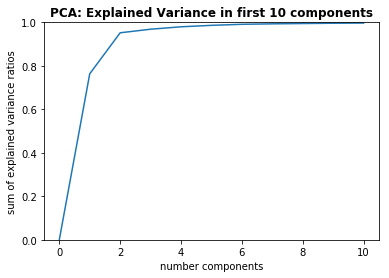

In [22]:
# project data across N-dimensions
n_comp = 10
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(X_train)

# cummulative ratio of explained variance
varRatio = pca_mod.explained_variance_ratio_
sumVarRatio = np.cumsum(np.concatenate(([0], varRatio)))

# plot the data to visualize
plt.plot(range(n_comp+1),sumVarRatio)
plt.xlabel('number components')
plt.ylabel('sum of explained variance ratios')
plt.ylim([0,1])
plt.title("PCA: Explained Variance in first 10 components", 
          fontsize=12, fontweight="bold")

In [23]:
print("First component = {:.2f}%".format(pca_mod.explained_variance_ratio_[0]*100))
print("Second component = {:.2f}%".format(pca_mod.explained_variance_ratio_[1]*100))
print("Together, these two components make up {:.2f}% of all variance in our dataset".format((pca_mod.explained_variance_ratio_[0]+pca_mod.explained_variance_ratio_[1])*100))

First component = 76.34%
Second component = 18.86%
Together, these two components make up 95.20% of all variance in our dataset


A lot of variance can be summarized in the first two components, let's see which features are contributing the most to these two components:

In [24]:
most_variance = []

# top three components
for variance in pca_mod.components_[:3]:
    
    variance_components = zip(list(df),np.abs(variance))
    sorted_variance = list(reversed(sorted(variance_components, key=lambda tup: tup[1])))

    most_variance.append(sorted_variance)

In [25]:
for i in range(len(most_variance)):
    print("Top features in component {}".format(i+1))
    print("-"*40)
    for name,value in most_variance[i][:10]:
        print("{0} = {1:.2f}%".format(name,(value*100)))
    print("\n")

Top features in component 1
----------------------------------------
totalDamageDealt = 75.42%
physicalDamageDealt = 55.09%
totalDamageDealtToChampions = 20.70%
magicDamageDealt = 16.06%
physicalDamageDealtToChampions = 14.40%
totalDamageTaken = 10.10%
damageSelfMitigated = 6.98%
goldSpent = 6.11%
physicalDamageTaken = 5.99%
damageDealtToObjectives = 5.55%


Top features in component 2
----------------------------------------
magicDamageDealt = 70.79%
physicalDamageDealt = 58.10%
totalDamageDealt = 25.35%
magicDamageDealtToChampions = 21.43%
physicalDamageDealtToChampions = 14.51%
trueDamageDealt = 12.66%
totalDamageDealtToChampions = 8.45%
damageDealtToTurrets = 4.71%
damageDealtToObjectives = 4.35%
damageSelfMitigated = 3.51%


Top features in component 3
----------------------------------------
damageSelfMitigated = 62.13%
totalDamageTaken = 54.55%
physicalDamageTaken = 41.67%
damageDealtToObjectives = 18.96%
damageDealtToTurrets = 18.37%
trueDamageDealt = 13.19%
magicalDamageTaken 

We see that features describing damage dealt have very high explantory power in this dataset. This was an expected result but it's surprising just how overwhelming all those features are. We see "gold spent" ranking highly as well. This was not explored during EDA, but it is worth considering the subtlety that while it is intuitive to think a new player that is catching on to the game faster would have higher "gold earned", they would also be picking up on the game mechanic of spending that gold. In League of Legends there it is not shoved in your face or forced in any way that you spend your gold so it takes a player actually exploring the game's features to spend gold.

This PCA data may be useful to us in the future, but for now let's move on with our dataset as it stands now and try to fit a model to our prediction task (yup! no more detours, we're _finally_ there! :D ).

### Logistic Regression Model

In [20]:
log_model = LogisticRegression()
log_model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
logistic_accuracy = log_model.score(X_test, Y_test)
preds = log_model.predict(X_test)
log_f1 = f1_score(Y_test, preds)
print("Accuracy of logistic regression model on test data: {:.2f}%".format(logistic_accuracy*100))
print("F1-score for logistic regression model on test data: {:.2f}".format(log_f1))

Accuracy of logistic regression model on test data: 74.25%
F1-score for logistic regression model on test data: 0.84


**Not bad at all!**

There are a lot of qualifiers we should point out about this result before we jump for joy, but 74% accuracy on this relatively small dataset with just a vanilla, out of the box, logistic regression model is very encouraging.

Next, let's try some other out of the box models.

### Decision Tree Model

In [22]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
tree_accuracy = tree_model.score(X_test, Y_test)
preds = tree_model.predict(X_test)
tree_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(tree_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(tree_f1))

Accuracy of ada boosted model on test data: 64.21%
F1-score for ada boosted model on test data: 0.76


### Random Forest Model

In [24]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
forest_accuracy = forest_model.score(X_test, Y_test)
preds = forest_model.predict(X_test)
forest_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(forest_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(forest_f1))

Accuracy of ada boosted model on test data: 70.90%
F1-score for ada boosted model on test data: 0.82


### Gradient Boosting Model

In [26]:
gradient_model = GradientBoostingClassifier()
gradient_model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [27]:
gradient_accuracy = gradient_model.score(X_test, Y_test)
preds = gradient_model.predict(X_test)
gradient_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(gradient_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(gradient_f1))

Accuracy of ada boosted model on test data: 73.91%
F1-score for ada boosted model on test data: 0.84


### Ada Boosting Model

In [28]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [29]:
ada_accuracy = ada_model.score(X_test, Y_test)
preds = ada_model.predict(X_test)
ada_f1 = f1_score(Y_test, preds)
print("Accuracy of ada boosted model on test data: {:.2f}%".format(ada_accuracy*100))
print("F1-score for ada boosted model on test data: {:.2f}".format(ada_f1))

Accuracy of ada boosted model on test data: 70.90%
F1-score for ada boosted model on test data: 0.81


<h3>Summary of Basic Models</h3>

<br>

<table align="left" style="width:30%">
    <tr>
        <th>Model Type</th>
        <th>Accuracy</th>
        <th>F1-Score</th>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>74.25%</td>
        <td>0.84</td>
    </tr>
    <tr>
        <td>Decision Tree</td>
        <td>62.21%</td>
        <td>0.74</td>
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>70.90%</td>
        <td>0.82</td>
    </tr>
    <tr>
        <td>Gradient Boosting</td>
        <td>73.91%</td>
        <td>0.84</td>
    </tr>
    <tr>
        <td>Ada Boosting</td>
        <td>70.90%</td>
        <td>0.81</td>
    </tr>
</table>

<br>

<p style="padding-left:350px;"> We achieved good results with logistic regression and random forests without any hyperparameter tuning. Because logistic regression worked so well, I'm curious how a small feed-forward neural network will fare on this dataset. </p>

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section4'></a>

## Step 4) Neural network model [currently under development]

This was originally part of step 3, so it was never intended to be part of this workflow, but I ended up putting more time into building and tuning this network than I thought I would so I decided to give it its own section in the notebook.

In [49]:
# transpose train/test set to prepare for neural network
X_train_network = X_train.T
X_test_network = X_test.T
Y_train_network = Y_train.reshape(1, Y_train.shape[0])
Y_test_network = Y_test.reshape(1, Y_test.shape[0])

In [50]:
print("Training set shape: {}".format(X_train_network.shape))
print("Training labels shape: {}".format(Y_train_network.shape))
print("\n")
print("Test set shape: {}".format(X_test_network.shape))
print("Test labels shape: {}".format(Y_test_network.shape))

Training set shape: (115, 2463)
Training labels shape: (1, 2463)


Test set shape: (115, 274)
Test labels shape: (1, 274)


In [85]:
def neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                   num_layers, nodes_in_layer, num_epochs, learning_rate, L2=False, beta=0.01,
                   optimization="gradient descent", verbose=False, report_cost=None,
                   hypertune_mode=False, dropout=False, keep_prob=None, save_loss_plot=False):

    if not report_cost:
        report_cost = num_epochs/10
    
    if dropout and not keep_prob:
        keep_prob = 0.8
    
    # to allow re-running of the network
    ops.reset_default_graph()                         
    
    # make sure all layers are assigned nodes
    assert num_layers == len(nodes_in_layer)

    
    costs = []
    parameters = {}
    activations = {}
     
        
    # step 1) placeholders for data

    X = tf.placeholder(tf.float32, shape=[X_train_network.shape[0], None], name="X_data")
    Y = tf.placeholder(tf.float32, shape=[Y_train_network.shape[0], None], name="Y_data")

    
    # step 2) initialize network parameters

    parameters["W1"] = tf.get_variable("W1", [nodes_in_layer[0],X_train_network.shape[0]], initializer = tf.contrib.layers.xavier_initializer(seed=2))
    parameters["b1"] = tf.get_variable("b1", [nodes_in_layer[0],1], initializer = tf.contrib.layers.xavier_initializer(seed=2))
    
    if verbose:
        print("W1 shape = {}".format(parameters["W1"].get_shape()))
        print("b1 shape = {}".format(parameters["b1"].get_shape()))

    for i in range(1,num_layers):
        parameters["W{}".format(i+1)] = tf.get_variable("W{}".format(i+1), [nodes_in_layer[i],nodes_in_layer[i-1]], 
                                                        initializer = tf.contrib.layers.xavier_initializer(seed=2))
        
        if verbose:
            print("W{0} shape = {1}".format((i+1),parameters["W{}".format(i+1)].get_shape()))
            
        parameters["b{}".format(i+1)] = tf.get_variable("b{}".format(i+1), [nodes_in_layer[i], 1], 
                                                        initializer = tf.contrib.layers.xavier_initializer(seed=2))
        
        if verbose:
            print("b{0} shape = {1}".format((i+1),parameters["b{}".format(i+1)].get_shape()))

        
    # step 3) forward propagation
    
    activations["Z1"] = tf.add(tf.matmul(parameters["W1"], X), parameters["b1"])
    activations["A1"] = tf.nn.tanh(activations["Z1"])
    
    if verbose:
        print("Z1 shape = {}".format(activations["Z1"].get_shape()))
        print("A1 shape = {}".format(activations["A1"].get_shape()))
    
    for i in range(1,num_layers-1):
        activations["Z{}".format(i+1)] = tf.add(tf.matmul(parameters["W{}".format(i+1)],
                                                          activations["A{}".format(i)]), parameters["b{}".format(i+1)])
        
        if verbose:
            print("Z{0} shape = {1}".format((i+1),activations["Z{}".format(i+1)].get_shape()))
        
        activations["A{}".format(i+1)] = tf.nn.tanh(activations["Z{}".format(i+1)])  
        
        if verbose:
            print("A{0} shape = {1}".format((i+1),activations["A{}".format(i+1)].get_shape()))
     
    
#     activations["A{}".format(num_layers-1)] = tf.nn.dropout(activations["A{}".format(num_layers-1)], keep_prob)

    activations["Z{}".format(num_layers)] = tf.add(tf.matmul(parameters["W{}".format(num_layers)],
                                                             activations["A{}".format(num_layers-1)]), parameters["b{}".format(num_layers)])
    
    if verbose:
        print("Z{0} shape = {1}".format((num_layers),activations["Z{}".format(num_layers)].get_shape()))

        
    # side step - adding dropout
    
    # step 4) compute cost & perform backprop
    
    logits = tf.transpose(activations["Z{}".format(num_layers)])
    labels = tf.transpose(Y)
    
    if L2:
        l2_reg = tf.nn.l2_loss(tf.transpose(parameters["W1"]))
        for i in range(1,num_layers):
            l2_reg += tf.nn.l2_loss(tf.transpose(parameters["W{}".format(i+1)]))
    
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
        
        cost = tf.reduce_mean(cost + beta * l2_reg)
        
        if optimization == "gradient descent":
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
        elif optimization == "adam":
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        else:
            raise NameError("optimization must be either 'gradient descent' or 'adam'")

    else:        
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
        
        if optimization == "gradient descent":
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
        elif optimization == "adam":
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        else:
            raise NameError("optimization must be either 'gradient descent' or 'adam'")
  
    
    # step 5) initialize and run Session
    
    # help measure progress for long runs
    interval = 100/num_epochs # for incrementing progress bar
    progress = widgets.FloatProgress(value=0.0, min=0.0, max=100.0, description='0%', bar_style='info')
    display(progress)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
    
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train_network, Y: Y_train_network})
                
            # Print the cost every epoch
            if ((epoch+1) % report_cost == 0) or ((epoch+1) == 1):
                print ("Cost after epoch {0}: {1}".format((epoch+1), epoch_cost))
            if epoch % 10 == 0:
                costs.append(epoch_cost)
            
            progress.value += interval
            progress.description = "{}%".format(round(progress.value,1))
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        
        if save_loss_plot:
            plt.savefig("./docs/nn_cost_high_res.png", dpi=750, bbox_inches="tight")
            
        plt.show()

        # lets save the parameters in a variable
        trained_parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        progress.style.bar_color = 'lightgreen'
        progress.value = 100.0
        progress.description = "100.0%"
        
        # Calculate the correct predictions        
        correct_prediction = tf.equal(tf.greater(activations["Z{}".format(num_layers)],0.5), tf.cast(Y, tf.bool))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        train_accuracy = accuracy.eval({X: X_train_network, Y: Y_train_network})
        test_accuracy = accuracy.eval({X: X_test_network, Y: Y_test_network})
        
        print ("Train Accuracy: {}".format(train_accuracy))
        print ("Test Accuracy: {}".format(test_accuracy))

        if hypertune_mode:
            return trained_parameters, train_accuracy, test_accuracy
        else:
            return trained_parameters

In [92]:
# I later realize I should be keeping track of which parameters are doing best...
hypertune = defaultdict(list)

## Testing the neural network

Now that we have our function set up nicely, there will likely be many iterations of models as I tune hyperparameters and decide what's best for this dataset. So **if you just want to see what ended up being the best model I could make, scroll to the very bottom of this notebook now.**

Now let's roll up our sleeves and get started!

Cost after epoch 0: 0.593246
Cost after epoch 100: 0.526663
Cost after epoch 200: 0.525855
Cost after epoch 300: 0.524321
Cost after epoch 400: 0.523534
Cost after epoch 500: 0.522908
Cost after epoch 600: 0.522393
Cost after epoch 700: 0.521955
Cost after epoch 800: 0.521579
Cost after epoch 900: 0.521247


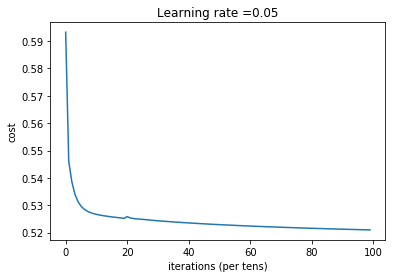

Parameters have been trained!
Train Accuracy: 0.769291341304779
Test Accuracy: 0.7599999904632568


In [90]:
# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 3
nodes_in_layer = [25,12,1]
num_epochs= 1000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

Great! Our neural network seems to be working well. Let's review some hyperparameters we've set for this network and consider how best to tune it.

**Hyperparameters:**

* Learning rate
* Number of epochs
* Number of layers
* Number of nodes per player
* Regularization
* Optimizer algorithm

These are a few things we might play around with to get better accuracy. I'm kind of hungry, so first I'm going to play with the number of epochs (set it all the way up to 1,000,000) while I go get lunch :D

Let's also start using desktop notifications so we know when this finishes training.

**Increasing number of epochs (to 1 million)**

W1 shape = (25, 115)
b1 shape = (25, 1)
W2 shape = (12, 25)
b2 shape = (12, 1)
W3 shape = (1, 12)
b3 shape = (1, 1)
Z1 shape = (25, ?)
A1 shape = (25, ?)
Z2 shape = (12, ?)
A2 shape = (12, ?)
Z3 shape = (1, ?)
Cost after epoch 0: 0.593246
Cost after epoch 10000: 0.511948
Cost after epoch 20000: 0.498437
Cost after epoch 30000: 0.492476
Cost after epoch 40000: 0.489381
Cost after epoch 50000: 0.487745
Cost after epoch 60000: 0.486808
Cost after epoch 70000: 0.486282
Cost after epoch 80000: 0.485969
Cost after epoch 90000: 0.485765
Cost after epoch 100000: 0.485624
Cost after epoch 110000: 0.485521
Cost after epoch 120000: 0.485443
Cost after epoch 130000: 0.485381
Cost after epoch 140000: 0.485332
Cost after epoch 150000: 0.485292
Cost after epoch 160000: 0.485258
Cost after epoch 170000: 0.485230
Cost after epoch 180000: 0.485206
Cost after epoch 190000: 0.485186
Cost after epoch 200000: 0.485168
Cost after epoch 210000: 0.485152
Cost after epoch 220000: 0.485172
Cost after epoch 23000

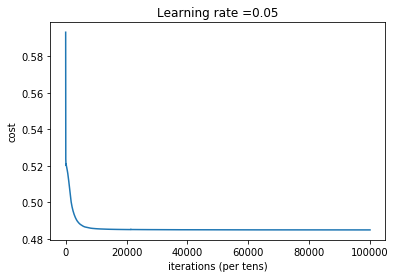

Parameters have been trained!
Train Accuracy: 0.78503937
Test Accuracy: 0.7511111
Wall time: 49min 31s


<IPython.core.display.Javascript object>

In [45]:
%%notify -m "1 million epoch training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 3
nodes_in_layer = [25,12,1]
num_epochs= 1000000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

It looks like the cost was coming to a minimum at around 20,000 epochs. Training for 1 million just caused us to overfit the data.

**Next let's try increasing the number and size of layers and rerunning with 20,000 epochs!**

W1 shape = (75, 115)
b1 shape = (75, 1)
W2 shape = (50, 75)
b2 shape = (50, 1)
W3 shape = (50, 50)
b3 shape = (50, 1)
W4 shape = (25, 50)
b4 shape = (25, 1)
W5 shape = (12, 25)
b5 shape = (12, 1)
W6 shape = (1, 12)
b6 shape = (1, 1)
Z1 shape = (75, ?)
A1 shape = (75, ?)
Z2 shape = (50, ?)
A2 shape = (50, ?)
Z3 shape = (50, ?)
A3 shape = (50, ?)
Z4 shape = (25, ?)
A4 shape = (25, ?)
Z5 shape = (12, ?)
A5 shape = (12, ?)
Z6 shape = (1, ?)
Cost after epoch 0: 0.577163
Cost after epoch 100: 0.528031
Cost after epoch 200: 0.524358
Cost after epoch 300: 0.521026
Cost after epoch 400: 0.518838
Cost after epoch 500: 0.517749
Cost after epoch 600: 0.515660
Cost after epoch 700: 0.513785
Cost after epoch 800: 0.513308
Cost after epoch 900: 0.510518
Cost after epoch 1000: 0.507958
Cost after epoch 1100: 0.505336
Cost after epoch 1200: 0.503134
Cost after epoch 1300: 0.501649
Cost after epoch 1400: 0.498434
Cost after epoch 1500: 0.496939
Cost after epoch 1600: 0.500093
Cost after epoch 1700: 0.49

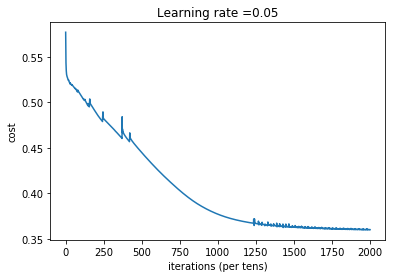

Parameters have been trained!
Train Accuracy: 0.82755905
Test Accuracy: 0.74666667
Wall time: 2min 46s


<IPython.core.display.Javascript object>

In [48]:
%%notify -m "6 layer neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 20000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

Hmm ok so with more layers and nodes we're seeing higher training accuracy but lower test accuracy. Let's try adding **L2 regularization** into the mix.

W1 shape = (75, 115)
b1 shape = (75, 1)
Z1 shape = (75, ?)
A1 shape = (75, ?)
Cost after epoch 0: 1.834868
Cost after epoch 1000: 0.991425
Cost after epoch 2000: 0.706543
Cost after epoch 3000: 0.602721
Cost after epoch 4000: 0.568588
Cost after epoch 5000: 0.558666
Cost after epoch 6000: 0.564629
Cost after epoch 7000: 0.557384
Cost after epoch 8000: 0.561389
Cost after epoch 9000: 0.556294
Cost after epoch 10000: 0.559462
Cost after epoch 11000: 0.552639
Cost after epoch 12000: 0.548497
Cost after epoch 13000: 0.572425
Cost after epoch 14000: 0.578250
Cost after epoch 15000: 0.579544
Cost after epoch 16000: 0.587152
Cost after epoch 17000: 0.579927
Cost after epoch 18000: 0.576593
Cost after epoch 19000: 0.573586


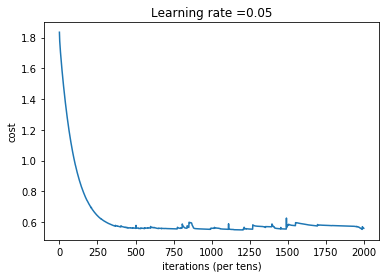

Parameters have been trained!
Train Accuracy: 0.7622047
Test Accuracy: 0.7688889
Wall time: 2min 44s


<IPython.core.display.Javascript object>

In [55]:
%%notify -m "6 layer neural network (with l2 loss) training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 20000
learning_rate = 0.01

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = True)

L2 loss has helped us get a similar accuracy between train and test sets but we aren't really seeing much improvement and our cost is just fluctuating after a couple hundred epochs. **Let's try lowering the learning rate considerably.** Because we're lowering the alpha considerably, we're also going to increase the number of epochs.

Cost after epoch 0: 1.834868
Cost after epoch 2000: 1.743892
Cost after epoch 4000: 1.690653
Cost after epoch 6000: 1.642418
Cost after epoch 8000: 1.597107
Cost after epoch 10000: 1.553827
Cost after epoch 12000: 1.512265
Cost after epoch 14000: 1.473534
Cost after epoch 16000: 1.436089
Cost after epoch 18000: 1.400683
Cost after epoch 20000: 1.366131
Cost after epoch 22000: 1.333043
Cost after epoch 24000: 1.301143
Cost after epoch 26000: 1.270533
Cost after epoch 28000: 1.241383
Cost after epoch 30000: 1.213429
Cost after epoch 32000: 1.186291
Cost after epoch 34000: 1.160371
Cost after epoch 36000: 1.135412
Cost after epoch 38000: 1.111436
Cost after epoch 40000: 1.088581
Cost after epoch 42000: 1.066564
Cost after epoch 44000: 1.045667
Cost after epoch 46000: 1.025677
Cost after epoch 48000: 1.005784
Cost after epoch 50000: 0.987193
Cost after epoch 52000: 0.968783
Cost after epoch 54000: 0.952954
Cost after epoch 56000: 0.936299
Cost after epoch 58000: 0.920072
Cost after epoch 6

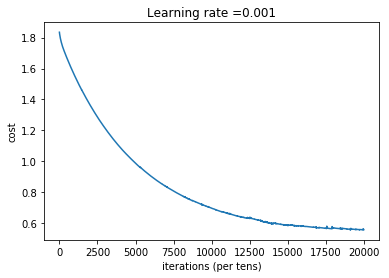

Parameters have been trained!
Train Accuracy: 0.7818897366523743
Test Accuracy: 0.7733333110809326
Wall time: 27min 56s


<IPython.core.display.Javascript object>

In [92]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 200000
learning_rate = 0.001
L2_regularization = True
optimizer = "gradient descent"
hypertune = True
save_plot = True

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                      num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization,
                      optimization=optimizer, hypertune_mode = True, save_loss_plot = save_plot)

A modest 2% improvement. We could decrease the learning rate a little more. Maybe also change the optimizer to something else like Adam. But let's settle for this accuracy for now.

However what would likely help even more is having more data. So I'll do that first. In the first Jupyter notebook ("Data Collection") you'll see a new round of data collection (round 9) toward the very bottom of the notebook.

Now in the mean time, while we're waiting for more data to come in, let's kick off training on more models with our current dataset.

Cost after epoch 0: 2.098670
Cost after epoch 20000: 0.547367
Cost after epoch 40000: 0.544157
Cost after epoch 60000: 0.550620
Cost after epoch 80000: 0.547880
Cost after epoch 100000: 0.544075
Cost after epoch 120000: 0.547624
Cost after epoch 140000: 0.551167
Cost after epoch 160000: 0.549472
Cost after epoch 180000: 0.545942


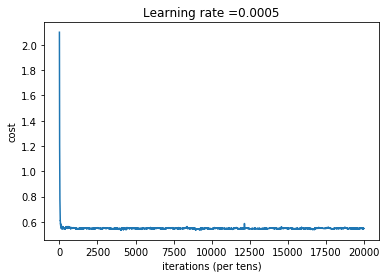

Parameters have been trained!
Train Accuracy: 0.7763779759407043
Test Accuracy: 0.7955555319786072
Wall time: 34min 47s


<IPython.core.display.Javascript object>

In [114]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 8
nodes_in_layer = [75,50,50,30,25,15,12,1]
num_epochs= 200000
learning_rate = 0.0005
L2_regularization = True
optimizer = "adam"

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization, optimization = optimizer)

In [115]:
current_parameters = test

Cost after epoch 0: 5.040148
Cost after epoch 20000: 4.829663
Cost after epoch 40000: 4.652678
Cost after epoch 60000: 4.486252
Cost after epoch 80000: 4.326179
Cost after epoch 100000: 4.171885
Cost after epoch 120000: 4.023908
Cost after epoch 140000: 3.880163
Cost after epoch 160000: 3.744143
Cost after epoch 180000: 3.613904


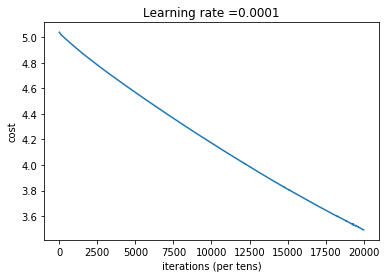

Parameters have been trained!
Train Accuracy: 0.8031495809555054
Test Accuracy: 0.7288888692855835
Wall time: 1h 43min 6s


<IPython.core.display.Javascript object>

In [119]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 16
nodes_in_layer = [100,100,85,75,80,70,62,50,50,50,40,30,25,15,12,1]
num_epochs= 200000
learning_rate = 0.0001
L2_regularization = True
optimizer = "gradient descent"

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization, optimization = optimizer)

HMMMM interesting, our training accuracy is getting much higher which is great but our test accuracy is going down meaning that we are overfitting our training data. Perhaps the best way to remedy that situation is to add more data... and hey look... **the bigger dataset just came in!**

Let's first test logistic regression again to see what we should consider our baseline here:

In [26]:
log_model = LogisticRegression()
log_model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
logistic_accuracy = log_model.score(X_test, Y_test)
preds = log_model.predict(X_test)
log_f1 = f1_score(Y_test, preds)
print("Accuracy of logistic regression model on test data: {:.2f}%".format(logistic_accuracy*100))
print("F1-score for logistic regression model on test data: {:.2f}".format(log_f1))

Accuracy of logistic regression model on test data: 72.51%
F1-score for logistic regression model on test data: 0.83


OK so essentially doubling the size of our dataset didn't help us improve our accuracy with logistic regression. But that's ok, not a big deal. Let's see how the first neural net we made (scroll up if you need a refresher) does with this bigger dataset:

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 0: 0.597110
Cost after epoch 100: 0.531008
Cost after epoch 200: 0.529504
Cost after epoch 300: 0.529800
Cost after epoch 400: 0.528983
Cost after epoch 500: 0.528476
Cost after epoch 600: 0.528175
Cost after epoch 700: 0.527852
Cost after epoch 800: 0.527588
Cost after epoch 900: 0.527347


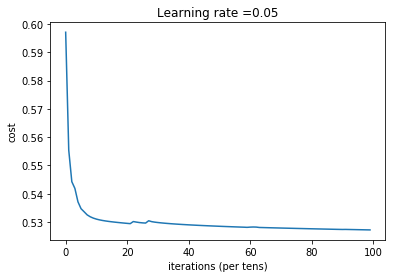

Parameters have been trained!
Train Accuracy: 0.7626827359199524
Test Accuracy: 0.7299270033836365


In [38]:
# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 3
nodes_in_layer = [25,12,1]
num_epochs= 1000
learning_rate = 0.05

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

Hmm we see roughly the same results but a surprising difference between test and train accuracy...

Let's test a neural network with 20,000 epochs, a lot more nodes and a much lower learning rate to see if we can get any advantage out of this bigger dataset.

_side note: I added a progress bar to help me see more precisely where a network is in the training process_

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 0: 5.041225
Cost after epoch 2000: 5.013398
Cost after epoch 4000: 4.991262
Cost after epoch 6000: 4.970123
Cost after epoch 8000: 4.949347
Cost after epoch 10000: 4.928844
Cost after epoch 12000: 4.908735
Cost after epoch 14000: 4.889032
Cost after epoch 16000: 4.869701
Cost after epoch 18000: 4.850713


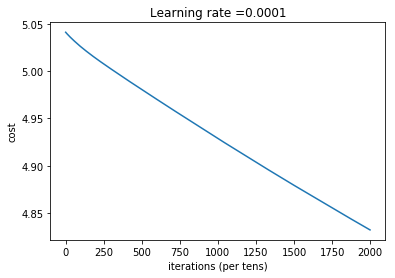

Parameters have been trained!
Train Accuracy: 0.7678418159484863
Test Accuracy: 0.7347931861877441
Wall time: 18min 20s


<IPython.core.display.Javascript object>

In [40]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 16
nodes_in_layer = [100,100,85,75,80,70,62,50,50,50,40,30,25,15,12,1]
num_epochs= 20000
learning_rate = 0.0001
L2_regularization = True
optimizer = "gradient descent"

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization, optimization = optimizer)

**OK two notes about this model:**

1) We're still getting a bit of a difference between test/train accuracy

2) Our cost is still decreasing linearly after 20,000 epochs

**Two changes for next model:**

1) fewer layers and less nodes per layer

2) raise learning rate

OK let's go!

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 1.8142063617706299
Cost after epoch 2000: 1.7005343437194824
Cost after epoch 4000: 1.6488189697265625
Cost after epoch 6000: 1.6029633283615112
Cost after epoch 8000: 1.5597598552703857
Cost after epoch 10000: 1.5187044143676758
Cost after epoch 12000: 1.479569435119629
Cost after epoch 14000: 1.4420876502990723
Cost after epoch 16000: 1.4058148860931396
Cost after epoch 18000: 1.3709570169448853
Cost after epoch 20000: 1.3377960920333862


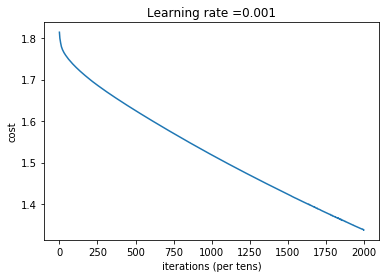

Parameters have been trained!
Train Accuracy: 0.7644023895263672
Test Accuracy: 0.7250608205795288
Wall time: 6min 15s


<IPython.core.display.Javascript object>

In [44]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 7
nodes_in_layer = [70,50,30,25,15,12,1]
num_epochs= 20000
learning_rate = 0.001
L2_regularization = True
optimizer = "gradient descent"

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization, optimization = optimizer)

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 1.411400318145752
Cost after epoch 2000: 1.0834616422653198
Cost after epoch 4000: 0.9030131101608276
Cost after epoch 6000: 0.7832704782485962
Cost after epoch 8000: 0.7032466530799866
Cost after epoch 10000: 0.6498012542724609
Cost after epoch 12000: 0.616100013256073
Cost after epoch 14000: 0.5927201509475708
Cost after epoch 16000: 0.5786928534507751
Cost after epoch 18000: 0.5698696374893188
Cost after epoch 20000: 0.5637071132659912


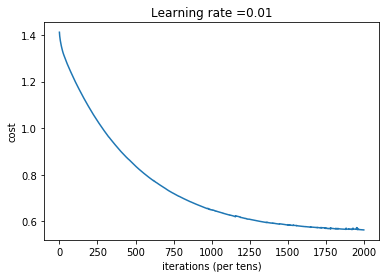

Parameters have been trained!
Train Accuracy: 0.7687016129493713
Test Accuracy: 0.7299270033836365
Wall time: 4min 43s


<IPython.core.display.Javascript object>

In [45]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [50,30,25,15,12,1]
num_epochs= 20000
learning_rate = 0.01
L2_regularization = True
optimizer = "gradient descent"

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization, optimization = optimizer)

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 0.5770103335380554
Cost after epoch 2000: 0.5053916573524475
Cost after epoch 4000: 0.4934016466140747
Cost after epoch 6000: 0.47872403264045715
Cost after epoch 8000: 0.4575656056404114
Cost after epoch 10000: 0.43724456429481506
Cost after epoch 12000: 0.4256719648838043
Cost after epoch 14000: 0.41264280676841736
Cost after epoch 16000: 0.40636515617370605
Cost after epoch 18000: 0.402555912733078
Cost after epoch 20000: 0.4002802073955536


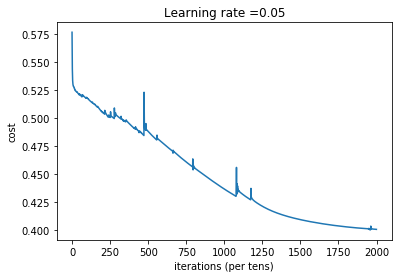

Parameters have been trained!
Train Accuracy: 0.8061048984527588
Test Accuracy: 0.6812652349472046
Wall time: 5min 49s


<IPython.core.display.Javascript object>

In [46]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 20000
learning_rate = 0.001

# train and test the network
test = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
               num_layers, nodes_in_layer, num_epochs, learning_rate)

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 1.8397951126098633
Cost after epoch 100: 1.65989351272583
Cost after epoch 200: 1.5231163501739502
Cost after epoch 300: 1.4032865762710571
Cost after epoch 400: 1.2969474792480469
Cost after epoch 500: 1.2030012607574463
Cost after epoch 600: 1.1203404664993286
Cost after epoch 700: 1.047351598739624
Cost after epoch 800: 0.9831026792526245
Cost after epoch 900: 0.9262617826461792
Cost after epoch 1000: 0.8773272037506104


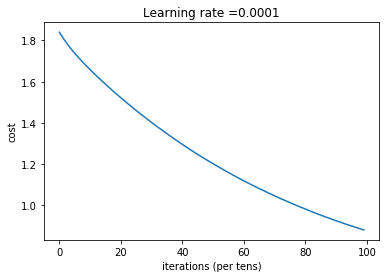

Parameters have been trained!
Train Accuracy: 0.7685748934745789
Test Accuracy: 0.7700729966163635
Wall time: 23.3 s


<IPython.core.display.Javascript object>

In [75]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 1000
learning_rate = 0.0001
L2_regularization = True
optimizer = "adam"

hypertune["num_epochs"].append(num_epochs)
hypertune["learning_rate"].append(learning_rate)
hypertune["num_layers"].append(num_layers)
hypertune["L2_reg"].append(L2_regularization)
hypertune["optimizer"].append(optimizer)

# train and test the network
_, train_accuracy, test_accuracy  = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                                                   num_layers, nodes_in_layer, num_epochs, learning_rate, 
                                                   L2 = L2_regularization, optimization = optimizer, hypertune_mode=True)

hypertune["train_accuracy"].append(train_accuracy)
hypertune["test_accuracy"].append(test_accuracy)

In [80]:
for key,value in hypertune.items():
    print(key,value)

num_epochs [1000]
learning_rate [0.0001]
num_layers [6]
L2_reg [True]
optimizer ['adam']
train_accuracy [0.7685749]
test_accuracy [0.770073]


FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 1.8397951126098633
Cost after epoch 100000: 0.33236515522003174
Cost after epoch 200000: 0.32377249002456665
Cost after epoch 300000: 0.27789366245269775
Cost after epoch 400000: 0.2946854829788208
Cost after epoch 500000: 0.2879863381385803
Cost after epoch 600000: 0.27169162034988403
Cost after epoch 700000: 0.27761971950531006
Cost after epoch 800000: 0.27038612961769104
Cost after epoch 900000: 0.2795579433441162
Cost after epoch 1000000: 0.2974315285682678


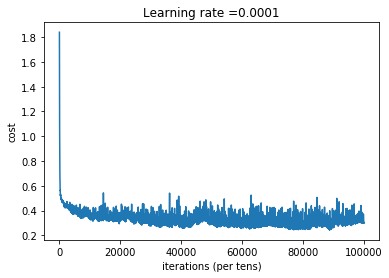

Parameters have been trained!
Train Accuracy: 0.9212342500686646
Test Accuracy: 0.6897810101509094
Wall time: 4h 49min 32s


<IPython.core.display.Javascript object>

In [81]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 1000000
learning_rate = 0.0001
L2_regularization = True
optimizer = "adam"

hypertune["num_epochs"].append(num_epochs)
hypertune["learning_rate"].append(learning_rate)
hypertune["num_layers"].append(num_layers)
hypertune["L2_reg"].append(L2_regularization)
hypertune["optimizer"].append(optimizer)

# train and test the network
_, train_accuracy, test_accuracy  = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                                                   num_layers, nodes_in_layer, num_epochs, learning_rate, 
                                                   L2 = L2_regularization, optimization = optimizer, hypertune_mode=True)

hypertune["train_accuracy"].append(train_accuracy)
hypertune["test_accuracy"].append(test_accuracy)

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 1.1709225177764893
Cost after epoch 10000: 0.48870304226875305
Cost after epoch 20000: 0.4508342146873474
Cost after epoch 30000: 0.4247768819332123
Cost after epoch 40000: 0.3719346225261688
Cost after epoch 50000: 0.3705783486366272
Cost after epoch 60000: 0.3588150143623352
Cost after epoch 70000: 0.3438021242618561
Cost after epoch 80000: 0.3297385573387146
Cost after epoch 90000: 0.34259045124053955
Cost after epoch 100000: 0.3425086438655853


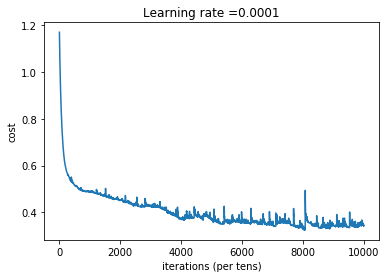

Parameters have been trained!
Train Accuracy: 0.8769792914390564
Test Accuracy: 0.7116788029670715
Wall time: 23min 5s


<IPython.core.display.Javascript object>

In [82]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 4
nodes_in_layer = [50,25,12,1]
num_epochs= 100000
learning_rate = 0.0001
L2_regularization = True
optimizer = "adam"

hypertune["num_epochs"].append(num_epochs)
hypertune["learning_rate"].append(learning_rate)
hypertune["num_layers"].append(num_layers)
hypertune["L2_reg"].append(L2_regularization)
hypertune["optimizer"].append(optimizer)

# train and test the network
_, train_accuracy, test_accuracy  = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                                                   num_layers, nodes_in_layer, num_epochs, learning_rate, 
                                                   L2 = L2_regularization, optimization = optimizer, hypertune_mode=True)

hypertune["train_accuracy"].append(train_accuracy)
hypertune["test_accuracy"].append(test_accuracy)

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 0.5743999481201172
Cost after epoch 10000: 0.2965209484100342
Cost after epoch 20000: 0.3451331853866577
Cost after epoch 30000: 0.30540937185287476
Cost after epoch 40000: 0.310161828994751
Cost after epoch 50000: 0.3093706965446472
Cost after epoch 60000: 0.3179401755332947
Cost after epoch 70000: 0.31856659054756165
Cost after epoch 80000: 0.33167752623558044
Cost after epoch 90000: 0.3538976311683655
Cost after epoch 100000: 0.3206169307231903


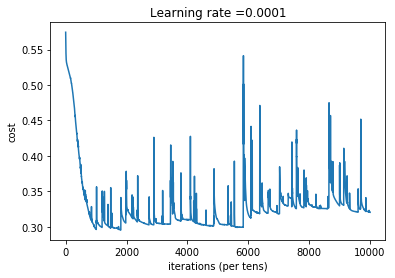

Parameters have been trained!
Train Accuracy: 0.8449046015739441
Test Accuracy: 0.6861313581466675
Wall time: 22min 5s


<IPython.core.display.Javascript object>

In [83]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 4
nodes_in_layer = [50,25,12,1]
num_epochs= 100000
learning_rate = 0.0001
L2_regularization = False
optimizer = "adam"

hypertune["num_epochs"].append(num_epochs)
hypertune["learning_rate"].append(learning_rate)
hypertune["num_layers"].append(num_layers)
hypertune["L2_reg"].append(L2_regularization)
hypertune["optimizer"].append(optimizer)

# train and test the network
_, train_accuracy, test_accuracy  = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                                                   num_layers, nodes_in_layer, num_epochs, learning_rate, 
                                                   L2 = L2_regularization, optimization = optimizer, hypertune_mode=True)

hypertune["train_accuracy"].append(train_accuracy)
hypertune["test_accuracy"].append(test_accuracy)

In [91]:
hyperparams

(1000, 0.0001, 6, True, 'adam', 0.01)

In [89]:
for key,value in hypertune.items():
    print(key,value)

AttributeError: 'bool' object has no attribute 'items'

FloatProgress(value=0.0, bar_style='info', description='0%')

Cost after epoch 1: 1.8397951126098633
Cost after epoch 50000: 1.0000675916671753
Cost after epoch 100000: 0.7095179557800293
Cost after epoch 150000: 0.5995803475379944
Cost after epoch 200000: 0.55843585729599
Cost after epoch 250000: 0.5542889833450317
Cost after epoch 300000: 0.555478036403656
Cost after epoch 350000: 0.5451802611351013
Cost after epoch 400000: 0.5493862628936768
Cost after epoch 450000: 0.5537885427474976
Cost after epoch 500000: 0.5529360175132751


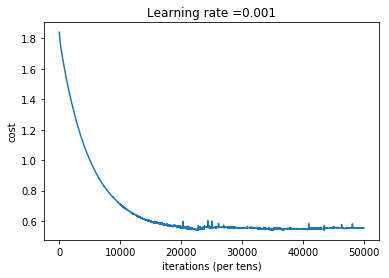

Parameters have been trained!
Train Accuracy: 0.7665448784828186
Test Accuracy: 0.7737226486206055
Wall time: 2h 23min 38s


<IPython.core.display.Javascript object>

In [94]:
%%notify -m "Neural network training complete!"
%%time

# seed for reproducibility
tf.set_random_seed(2)

# choose your parameters
num_layers = 6
nodes_in_layer = [75,50,50,25,12,1]
num_epochs= 500000
learning_rate = 0.001
L2_regularization = True
optimizer = "gradient descent"
hypertune_mode = True
save_plot = True

hypertune["num_epochs"].append(num_epochs)
hypertune["learning_rate"].append(learning_rate)
hypertune["num_layers"].append(num_layers)
hypertune["L2_reg"].append(L2_regularization)
hypertune["optimizer"].append(optimizer)

# train and test the network
_, train_accuracy, test_accuracy = neural_network(X_train_network, Y_train_network, X_test_network, Y_test_network, 
                                                  num_layers, nodes_in_layer, num_epochs, learning_rate, L2 = L2_regularization,
                                                  optimization=optimizer, hypertune_mode = hypertune_mode, save_loss_plot = save_plot)

hypertune["train_accuracy"].append(train_accuracy)
hypertune["test_accuracy"].append(test_accuracy)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>

## End of Part 3

## That's it!

We've seen that it is possible to predict (with great accuracy) whether a new League of Legends player will ge through their tutorial matches (reach summoner level 3) or not, based only on the gameplay data of that player's first match!